# Section 0: Import section

In [1]:
# pytorch 
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.functional import normalize
from torch.utils.data import DataLoader, TensorDataset

# Helper funcitons and classes
from helper_func_and_classes import create_dataset_list, create_submission_file, create_vocab
from helper_func_and_classes import split_dataset, create_scaled_matrix_tensor
from helper_func_and_classes import word_vec_to_aggregated_word_embeddings
from helper_func_and_classes import TwitterDataset, NN, create_data_loader_GloVe
from helper_func_and_classes import get_count_of_longest_sentence
from helper_func_and_classes import output_numpy_array_from_model_training
from helper_func_and_classes import output_numpy_array_from_model_submission

# word embeddings
from torchtext.vocab import GloVe

# scikit-learn
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# plotting 
import matplotlib.pyplot as plt

#data science
from tqdm import tqdm
import time
import warnings

# random state
RANDOM_SEED = 123 # used in helper functions
torch.manual_seed(RANDOM_SEED)
warnings.simplefilter(action='ignore', category=FutureWarning);

# Section 1: Data preprocessing section
This section will extract the data from the three different .txt files. Then, the helper functions will process the tweets to create our vocabulary and three python lists for positive, negative, and submission tweets. The tweets are pre tokenized, so we only split on white space.

In [2]:
# creating the text vocabulary from the whole data set, including positive, negative and test data.
text_vocab_full = create_vocab("./twitter-datasets/train_pos_full.txt",
                          "./twitter-datasets/train_neg_full.txt",
                          "./twitter-datasets/test_data.txt")

text_vocab_lite = create_vocab("./twitter-datasets/train_pos.txt",
                          "./twitter-datasets/train_neg.txt",
                          "./twitter-datasets/test_data.txt")

# creating a standard python library list of the tweets that will be used for submission, 1 tweet per index
submission_data = create_dataset_list("./twitter-datasets/test_data.txt")

print("Length of text_vocab_full: ", len(text_vocab_full))
print("Length of text_vocab_lite: ", len(text_vocab_lite))
print("Length of submission_data: ",len(submission_data))

100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 861766.56it/s]


Length of text_vocab_full:  604014
Length of text_vocab_lite:  127802
Length of submission_data:  10000


Here we will create the TwitterDataset class which contains all the pre processed data, here we do not have any cutoff since we can have any length for the quotes since they are just aggregated over the same dimensions.

Furthermore we will split and shuffle the dataset into training and testing. The longest sentences is also located by using the get_count_of_longest_sentence on the dataset.

In [3]:
# Creating the dataset in the TwitterDataset class which is found in the helper functions
dataset_full = TwitterDataset(text_vocab_full,
                              create_dataset_list("./twitter-datasets/train_pos_full.txt"),
                              create_dataset_list("./twitter-datasets/train_neg_full.txt"),
                              submission_data,
                              1000)

dataset_lite = TwitterDataset(text_vocab_lite, 
                              create_dataset_list("./twitter-datasets/train_pos.txt"),
                              create_dataset_list("./twitter-datasets/train_neg.txt"),
                              submission_data,
                              1000)

# create training dataset and test dataset - using a split of 85% / 15%
train_dataset_full, test_dataset_full = split_dataset(dataset_full, 0.9);
train_dataset_lite, test_dataset_lite = split_dataset(dataset_lite, 0.9);

# calculating the longest sentence
max_len_full = get_count_of_longest_sentence(dataset_full)
max_len_lite = get_count_of_longest_sentence(dataset_lite)

100%|██████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 132175.88it/s]


Number of elements in train_data is:  2250000
Number of elements in test_data is:  250000
Number of elements in train_data is:  180000
Number of elements in test_data is:  20000


**Setting the parameters for the data loading part:**

In [4]:
batch_size = 16
dim_norm = -1
p_norm = 1.0
vec_dim = 200
glove_vec = GloVe(name='twitter.27B', dim=vec_dim)

**Creating the GloVe word embeddings from the vocabulary:**

In [5]:
word_embeddings_lite = glove_vec.get_vecs_by_tokens(list(text_vocab_lite.keys()), lower_case_backup=True)
word_embeddings_full = glove_vec.get_vecs_by_tokens(list(text_vocab_full.keys()), lower_case_backup=True)

**Creating the word embedding vectors and normalizing data:**

In [6]:
s_train_full,s_train_lite,s_test_full,s_test_lite,labels_train_full,labels_train_lite,labels_test_full,labels_test_lite = create_scaled_matrix_tensor(
    train_dataset_full,
    train_dataset_lite,
    test_dataset_full,
    test_dataset_lite,
    word_embeddings_full,
    word_embeddings_lite,
    vec_dim,
    p_norm,
    dim_norm)

2250000it [01:52, 20018.59it/s]
/Users/fritt/Documents/epfl/cs433/project/project2/project_text_classification/helper_func_and_classes.py:564: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_train_full_tensor = torch.tensor(matrix_train_full).type(torch.float)
250000it [00:17, 14549.25it/s]
/Users/fritt/Documents/epfl/cs433/project/project2/project_text_classification/helper_func_and_classes.py:571: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_test_full_tensor = torch.tensor(matrix_test_full).type(torch.float)
180000it [00:09, 18027.00it/s]
/Users/fritt/Documents/epfl/cs433/project/project2/project_text_classification/helper_func_and_classes.py:579: UserWarning: To copy cons

In [7]:
print("Shape of s_train_full: ", s_train_full.shape)
print("Shape of s_test_full: ", s_test_full.shape)
print("Shape of s_train_lite: ", s_train_lite.shape)
print("Shape of s_test_lite: ", s_test_lite.shape)

Shape of s_train_full:  torch.Size([2250000, 200])
Shape of s_test_full:  torch.Size([250000, 200])
Shape of s_train_lite:  torch.Size([180000, 200])
Shape of s_test_lite:  torch.Size([20000, 200])


**Creating dataloaders for full data and supbart of full data:**

In [8]:
train_loader_full, test_loader_full = create_data_loader_GloVe(
    s_train_full, 
    s_test_full,
    labels_train_full,
    labels_test_full,
    batch_size=batch_size)

train_loader_lite, test_loader_lite = create_data_loader_GloVe(
    s_train_lite, 
    s_test_lite,
    labels_train_lite,
    labels_test_lite,
    batch_size=batch_size)

# Section 2: Neural network
#### Pretrained word embeddings (dim=200) 
Here we will use pre-trained Global Vector word embeddings (Glove); these will have a dimension of 200 per word. The pre-trained word embeddings were downloaded from https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html#GloVe. The word embedding used has been trained on Twitter data, which will increase accuracy since our corpus also consists of Twitter data.

## Section 2.1: Choosing best parameters

In [9]:
# Finding best parameters for neural network
input_dim = 200
num_classes = 2
epoch_options = [3, 5]
lr_options = [1e-4, 5e-4, 1e-3]
drop_options = [0.1, 0.2, 0.3]

all_options = []
for i in epoch_options:
    for j in lr_options:
        for k in drop_options:
             all_options.append([i,j,k])
                
precision_list = []
recall_list = []
f1score_list = []
support_list = []

**Testing model for different parameters on the subpart of full dataset:**

In [10]:
%%time

for epoch_i, lr_i, drop_i in all_options:
    start_time = time.time()
    print(f"Epoch: {epoch_i} | Learning rate: {lr_i} | Dropout probability: {drop_i}")
    
    model = NN(input_size=input_dim, num_classes=num_classes, p=drop_i)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr_i)
    for epoch in range(epoch_i):
        for data, labels in train_loader_lite:

            model_score = model(data)
            loss = criterion(model_score, labels)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
    
    
    # creating status report for current iteration
    predicted_labels = output_numpy_array_from_model_training(test_loader_lite, model)
    
    class_report = classification_report(labels_test_lite, predicted_labels, output_dict=True)['macro avg']
    
    # appending results to corresponding list
    precision_list.append(class_report['precision'])
    recall_list.append(class_report['recall'])
    f1score_list.append(class_report['f1-score'])
    support_list.append(class_report['support'])
    print("Time of current iteration: ", time.time()-start_time)
    print(class_report, "\n")

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.1
Time of current iteration:  78.25256872177124
{'precision': 0.7974285014260523, 'recall': 0.7968865130793907, 'f1-score': 0.7968429966984686, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.2
Time of current iteration:  72.60966229438782
{'precision': 0.7973379439645444, 'recall': 0.7967858921124232, 'f1-score': 0.7967410689655327, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.3
Time of current iteration:  90.28890204429626
{'precision': 0.796391792340051, 'recall': 0.7960499900404043, 'f1-score': 0.7960294343431054, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0005 | Dropout probability: 0.1
Time of current iteration:  75.62051916122437
{'precision': 0.7966489645780148, 'recall': 0.7963537129591816, 'f1-score': 0.7963383393956354, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0005 | Dropout probability: 0.2
Time of current iteration:  69.20431709289551
{'preci

**Plotting our findings:**

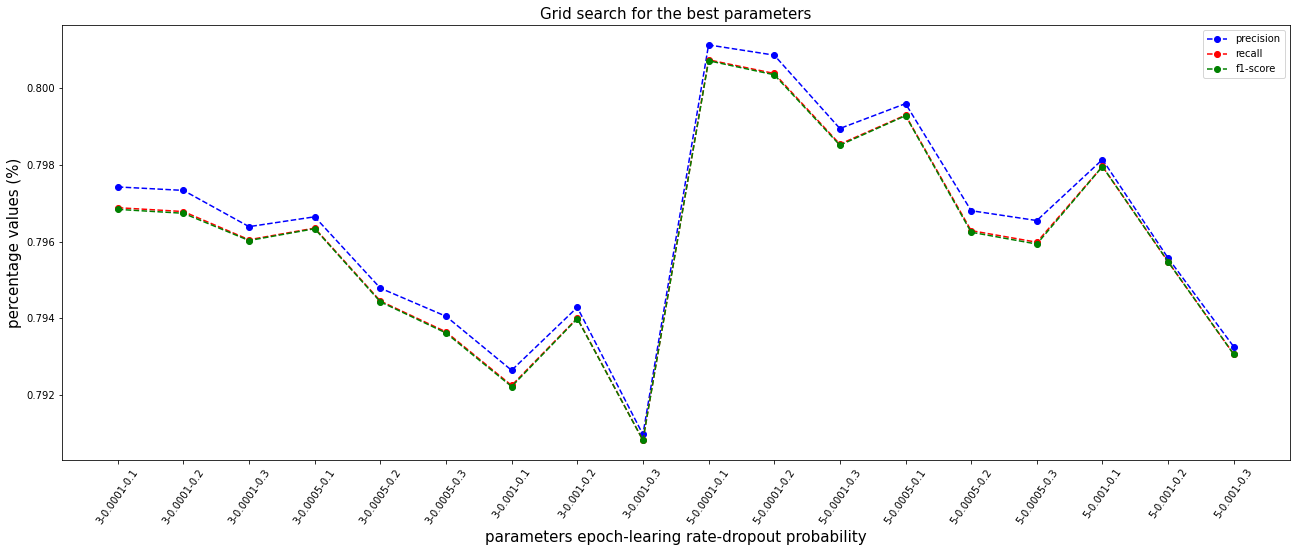

In [17]:
all_options_str = [f"{a}-{b}-{c}" for a,b,c in all_options]



plt.rcParams["figure.figsize"] = (22,8)

plt.xticks(rotation='55', fontsize=10)
plt.plot(all_options_str, precision_list, linestyle='--', marker='o', color='blue', label='precision')
plt.plot(all_options_str, recall_list, linestyle='--', marker='o', color='red', label='recall')
plt.plot(all_options_str, f1score_list, linestyle='--', marker='o', color='green', label='f1-score')
plt.title("Grid search for the best parameters", fontsize=15)
plt.xlabel("parameters epoch-learing rate-dropout probability", fontsize=15)
plt.ylabel("percentage values (%)", fontsize=15)

plt.legend()
plt.show();

## Section 2.2: Training the Neural Network

**Using the best parameters found in last step:**

In [18]:
input_dim = 200
num_classes = 2
learning_rate = 0.0001
num_epochs = 5
drop_probability = 0.1

In [19]:
model = NN(input_size=input_dim, num_classes=num_classes, p=drop_probability)

In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(epoch_i):
    for data, labels in tqdm(train_loader_full):

        model_score = model(data)
        loss = criterion(model_score, labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

100%|█████████████████████████████████████████████████████████| 140625/140625 [04:34<00:00, 512.99it/s]


In [23]:
predicted_labels = output_numpy_array_from_model_training(test_loader_full, model)
print(classification_report(labels_test_full, predicted_labels, digits=4))

              precision    recall  f1-score   support

         0.0     0.8224    0.8078    0.8151    124929
         1.0     0.8114    0.8258    0.8185    125071

    accuracy                         0.8168    250000
   macro avg     0.8169    0.8168    0.8168    250000
weighted avg     0.8169    0.8168    0.8168    250000



# Section 3: Creating submission

In [22]:
submission_matrix, id_submission_matrix = word_vec_to_aggregated_word_embeddings(
    dataset_full.submission_dataset,
    word_embeddings_full,
    200)
submission_tensor = torch.tensor(submission_matrix).type(torch.float)
scaled_submission_matrix = normalize(submission_tensor, p=p_norm, dim=dim_norm)
submission_dataset = TensorDataset(scaled_submission_matrix, torch.tensor(id_submission_matrix).type(torch.float))
submission_loader = DataLoader(dataset=submission_dataset, batch_size=batch_size,  shuffle=False)

submission_numpy_array = output_numpy_array_from_model_training(submission_loader, model)
submission_numpy_array

10000it [00:00, 21572.13it/s]
/var/folders/pc/5ytjzw0165n86jc4_pv2802c0000gn/T/ipykernel_87102/3301144756.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  submission_tensor = torch.tensor(submission_matrix).type(torch.float)
/var/folders/pc/5ytjzw0165n86jc4_pv2802c0000gn/T/ipykernel_87102/3301144756.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  submission_dataset = TensorDataset(scaled_submission_matrix, torch.tensor(id_submission_matrix).type(torch.float))


array([0., 0., 0., ..., 0., 1., 0.])

In [ ]:
create_submission_file(submission_numpy_array)